# 03 - Creating Training Matrix

This notebook creates a training matrix (table with feature variables and target variables) using the historic weather and bikes data available.

STEPS:

- 03.01 - Import libraries
- 03.02 - Import bikes and weather data
- 03.03 - Keep only complete dates
- 03.04 - Joing both dataframes
- 03.05 - Add variables
- 03.06 - Save as csv

# 03.01 Import Libraries
Let's import the libraries we will be using.

In [48]:
import pandas as pd
import pandas as pd
import pytz
from dateutil import tz

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
sns.set()

# 03.02 Import bikes and weather data
Choose to query our provide sample of data or your queries performed in the previous notebooks.

## 03.02.01 Bikes

In [50]:
# BIKES historic data
df = pd.read_csv('NY_historic_data.csv') # This is to load the sample data we provided
# df = pd.read_csv('Quix_query_NY_historic_data.csv') # Uncomment this if you want to load your Quix data (there may not be much historic data there yet)

# Correct timestamp format
df['Timestamp_NY'] = pd.to_datetime(df['Timestamp_NY'])

# Ensure values are sorted by date
df = df.sort_values('Timestamp_NY', ascending=True).reset_index(drop=True)

# Check the size and visualise some rows
print(df.shape)
df.head()

(30196, 3)


,Timestamp_NY,total_num_bikes_available,Origin
0,2021-08-01 00:04:42.938724-04:00,19275.0,3
1,2021-08-01 00:09:43.037694-04:00,19382.0,3
2,2021-08-01 00:14:43.229910-04:00,19368.0,3
3,2021-08-01 00:19:43.530587-04:00,19416.0,3
4,2021-08-01 00:24:43.935994-04:00,19394.0,3


## 03.01.02 Weather

In [51]:
# Weather historic data
df_weather = pd.read_csv('weather.csv')
# df_weather = pd.read_csv('Quix_query_weather.csv') # Uncomment this if you want to load your Quix data (there may not be much historic data there yet)

# Correct timestamp format
df_weather['Timestamp_NY'] = pd.to_datetime(df_weather['Timestamp_NY'])

# Ensure values are sorted by date
df_weather = df_weather.sort_values('Timestamp_NY', ascending=True).reset_index(drop=True)

# Check the size and visualise some rows
print(df_weather.shape)
df_weather.head()

(1076, 6)


,Timestamp_NY,wind_kph,feelslike_temp_c,condition,Forecast,Origin
0,2021-08-11 09:46:01.817855-04:00,14.256,8.02,Clear,NextDay,2
1,2021-08-11 09:46:01.817855-04:00,7.884,4.25,Clear,Current,2
2,2021-08-11 10:46:02.053303-04:00,7.812,4.04,Clear,NextDay,2
3,2021-08-11 10:46:02.053303-04:00,1.692,3.97,Clear,Current,2
4,2021-08-11 11:46:02.938583-04:00,3.564,3.63,Clear,Current,2


We have now two rows per timestamp (one for the current forecast and one for the next day forecast).Let's flatten the data:

In [52]:
# Create two dataframes
df_weather_current = df_weather[df_weather['Forecast']=='Current']
df_weather_nextday = df_weather.loc[df_weather['Forecast']=='NextDay', ['Timestamp_NY', 'wind_kph', 'feelslike_temp_c', 'condition']]
df_weather_nextday.columns = ['Timestamp_NY', 'wind_kph_24', 'feelslike_temp_c_24', 'condition_24']

In [53]:
# Joing both dataframes
df_weather = pd.merge(df_weather_current[['Timestamp_NY', 'wind_kph', 'feelslike_temp_c', 'condition']], 
                      df_weather_nextday, 
                      on='Timestamp_NY', 
                      how='left')
df_weather.head()

,Timestamp_NY,wind_kph,feelslike_temp_c,condition,wind_kph_24,feelslike_temp_c_24,condition_24
0,2021-08-11 09:46:01.817855-04:00,7.884,4.25,Clear,14.256,8.02,Clear
1,2021-08-11 10:46:02.053303-04:00,1.692,3.97,Clear,7.812,4.04,Clear
2,2021-08-11 11:46:02.938583-04:00,3.564,3.63,Clear,3.924,4.13,Clear
3,2021-08-11 12:46:03.319603-04:00,6.480,1.69,Clear,3.528,3.54,Clear
4,2021-08-11 13:46:03.921296-04:00,7.236,1.13,Clear,2.988,2.84,Clear


# 03.03 - Keep only complete dates 
Keep only those dates with both bikes and weather data and join the two dataframes together.

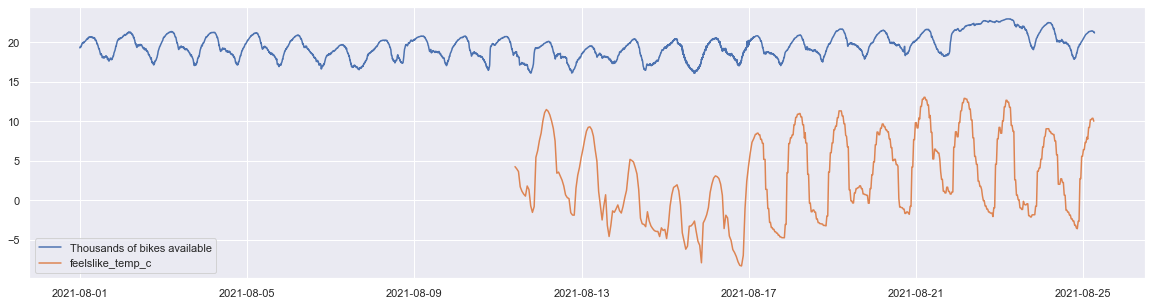

In [54]:
# Visually check complete dates
plt.plot(df['Timestamp_NY'], df['total_num_bikes_available']/1000, label='Thousands of bikes available')
plt.plot(df_weather['Timestamp_NY'], df_weather['feelslike_temp_c'], label='feelslike_temp_c')
plt.legend()
plt.show()

Let's now cut the bikes data to limit it to the first available date for the weather data:

In [55]:
# Keeping only complete dates and usefull columns
df = df.loc[df['Timestamp_NY']>df_weather['Timestamp_NY'][0], ['Timestamp_NY', 'total_num_bikes_available']].reset_index(drop=True)
df.head()

,Timestamp_NY,total_num_bikes_available
0,2021-08-11 09:50:30.343668-04:00,18621.0
1,2021-08-11 09:55:31.246784-04:00,18668.0
2,2021-08-11 10:00:32.147567-04:00,18763.0
3,2021-08-11 10:05:33.130733-04:00,18712.0
4,2021-08-11 10:10:33.839810-04:00,18722.0


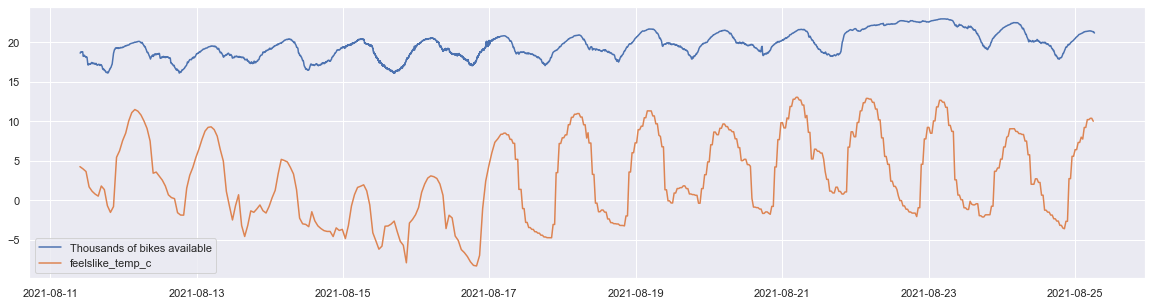

In [56]:
# Visually check complete dates
plt.plot(df['Timestamp_NY'], df['total_num_bikes_available']/1000, label='Thousands of bikes available')
plt.plot(df_weather['Timestamp_NY'], df_weather['feelslike_temp_c'], label='feelslike_temp_c')
plt.legend()
plt.show()

# 03.04 - Join both dataframes
Let's join both sources of data and do some little cleaning.

## 03.04.01 - Join bikes and weather
Lets put both dataframes together and fill the nulls.

In [57]:
# Add both sources of data and sort by date
df_all = df.append(df_weather).sort_values('Timestamp_NY', ascending=True).reset_index(drop=True)
df_all.head(15)

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,condition,wind_kph_24,feelslike_temp_c_24,condition_24
0,2021-08-11 09:46:01.817855-04:00,NaN,7.884,4.25,Clear,14.256,8.02,Clear
1,2021-08-11 09:50:30.343668-04:00,18621.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-11 09:55:31.246784-04:00,18668.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-11 10:00:32.147567-04:00,18763.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-11 10:05:33.130733-04:00,18712.0,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-08-11 10:10:33.839810-04:00,18722.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-08-11 10:15:34.129851-04:00,18744.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-08-11 10:20:34.438747-04:00,18741.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2021-08-11 10:25:34.734725-04:00,18723.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-08-11 10:30:35.633619-04:00,18785.0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Let's fill the weather (and bikes) nulls with the previous non-null value 
# This is what will happen in the prediction service: our weather prediction will be the last one available
df_all = df_all.fillna(method='ffill').dropna().reset_index(drop=True)
df_all.head(15)

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,condition,wind_kph_24,feelslike_temp_c_24,condition_24
0,2021-08-11 09:50:30.343668-04:00,18621.0,7.884,4.25,Clear,14.256,8.02,Clear
1,2021-08-11 09:55:31.246784-04:00,18668.0,7.884,4.25,Clear,14.256,8.02,Clear
2,2021-08-11 10:00:32.147567-04:00,18763.0,7.884,4.25,Clear,14.256,8.02,Clear
3,2021-08-11 10:05:33.130733-04:00,18712.0,7.884,4.25,Clear,14.256,8.02,Clear
4,2021-08-11 10:10:33.839810-04:00,18722.0,7.884,4.25,Clear,14.256,8.02,Clear
5,2021-08-11 10:15:34.129851-04:00,18744.0,7.884,4.25,Clear,14.256,8.02,Clear
6,2021-08-11 10:20:34.438747-04:00,18741.0,7.884,4.25,Clear,14.256,8.02,Clear
7,2021-08-11 10:25:34.734725-04:00,18723.0,7.884,4.25,Clear,14.256,8.02,Clear
8,2021-08-11 10:30:35.633619-04:00,18785.0,7.884,4.25,Clear,14.256,8.02,Clear
9,2021-08-11 10:35:36.430720-04:00,18794.0,7.884,4.25,Clear,14.256,8.02,Clear


## 03.04.02 - Sort timestamp every 5 min
We will use the shift() method later so let's ensure the time intervals between rows it's constant. 

In [59]:
# Timestamp_NY to become the dataframe timeindex
df_all.set_index('Timestamp_NY')

# Resample to 5 min intervals and then reset the index
df_all = df_all.set_index('Timestamp_NY').resample("5T").last().reset_index()
df_all.head()

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,condition,wind_kph_24,feelslike_temp_c_24,condition_24
0,2021-08-11 09:50:00-04:00,18621.0,7.884,4.25,Clear,14.256,8.02,Clear
1,2021-08-11 09:55:00-04:00,18668.0,7.884,4.25,Clear,14.256,8.02,Clear
2,2021-08-11 10:00:00-04:00,18763.0,7.884,4.25,Clear,14.256,8.02,Clear
3,2021-08-11 10:05:00-04:00,18712.0,7.884,4.25,Clear,14.256,8.02,Clear
4,2021-08-11 10:10:00-04:00,18722.0,7.884,4.25,Clear,14.256,8.02,Clear


# 03.05 - Add variables

## 03.05.01 - Add feature variables
Variables the the ML models will use to predict the targets.

In [60]:
# Dummify categorical variables
df_all = pd.get_dummies(df_all, columns=['condition', 'condition_24'])
df_all.head()

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,wind_kph_24,feelslike_temp_c_24,condition_Clear,condition_Clouds,condition_Rain,condition_Snow,condition_24_Clear,condition_24_Clouds,condition_24_Rain,condition_24_Snow
0,2021-08-11 09:50:00-04:00,18621.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0
1,2021-08-11 09:55:00-04:00,18668.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0
2,2021-08-11 10:00:00-04:00,18763.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0
3,2021-08-11 10:05:00-04:00,18712.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0
4,2021-08-11 10:10:00-04:00,18722.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0


In [61]:
# This function incorporates timestamp variables
def add_timestamp_variables(df): 
    df['year'] = df['Timestamp_NY'].dt.year
    df['month'] = df['Timestamp_NY'].dt.month
    df['day'] = df['Timestamp_NY'].dt.day
    df['hour'] = df['Timestamp_NY'].dt.hour
    df['minute'] = df['Timestamp_NY'].dt.minute
    df['dayofweek'] = df['Timestamp_NY'].dt.dayofweek
        
    return df

In [62]:
df_all = add_timestamp_variables(df_all)
df_all.head()

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,wind_kph_24,feelslike_temp_c_24,condition_Clear,condition_Clouds,condition_Rain,condition_Snow,condition_24_Clear,condition_24_Clouds,condition_24_Rain,condition_24_Snow,year,month,day,hour,minute,dayofweek
0,2021-08-11 09:50:00-04:00,18621.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0,2021,8,11,9,50,2
1,2021-08-11 09:55:00-04:00,18668.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0,2021,8,11,9,55,2
2,2021-08-11 10:00:00-04:00,18763.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0,2021,8,11,10,0,2
3,2021-08-11 10:05:00-04:00,18712.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0,2021,8,11,10,5,2
4,2021-08-11 10:10:00-04:00,18722.0,7.884,4.25,14.256,8.02,1,0,0,0,1,0,0,0,2021,8,11,10,10,2


## 03.05.02 - Add targets
Targets that the ML models will predict.

In [63]:
# If there is a row every 5 min:
# A difference of 60/5 rows equals a difference of 1 hour
# A difference of 24*60/5 rows equals a difference of 1 day

df_all['target_1h'] = df_all['total_num_bikes_available'].shift(-int(60/5))
df_all['target_1d'] = df_all['total_num_bikes_available'].shift(-int(24*60/5))

df_all.head(15)

,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,wind_kph_24,feelslike_temp_c_24,condition_Clear,condition_Clouds,condition_Rain,condition_Snow,...,condition_24_Rain,condition_24_Snow,year,month,day,hour,minute,dayofweek,target_1h,target_1d
0,2021-08-11 09:50:00-04:00,18621.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,9,50,2,18206.0,18239.0
1,2021-08-11 09:55:00-04:00,18668.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,9,55,2,18229.0,18338.0
2,2021-08-11 10:00:00-04:00,18763.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,0,2,18310.0,18440.0
3,2021-08-11 10:05:00-04:00,18712.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,5,2,18320.0,18438.0
4,2021-08-11 10:10:00-04:00,18722.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,10,2,18303.0,18431.0
5,2021-08-11 10:15:00-04:00,18744.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,15,2,18341.0,18495.0
6,2021-08-11 10:20:00-04:00,18741.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,20,2,18274.0,18447.0
7,2021-08-11 10:25:00-04:00,18723.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,25,2,18242.0,18469.0
8,2021-08-11 10:30:00-04:00,18785.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,30,2,18201.0,18508.0
9,2021-08-11 10:35:00-04:00,18794.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,35,2,18134.0,18400.0


# 03.06 - Save as csv
Let's save the training matrix as a csv locally.

In [64]:
df_all.to_csv('df_train.csv', index=False)